# 设置参数
配置的参数,需要与采集数据时雷达配置的参数一致

In [86]:
import torch
import os
import numpy as np
import glob
import numpy as np
import matplotlib.pyplot as plt
from RealTimeCollector.RealTimeCollector import RealTimeCollector
import scipy.io as sio

n_frames = 30   # 每个样本的帧数
rtc = RealTimeCollector(ip_address='127.0.0.100')

n_RX = 4  # RX天线通道总数
n_samples = 64  # 采样点数
n_chirps = 255  # 每帧脉冲数
N = 64  # 距离向FFT点数
M = 64  # 多普勒向FFT点数
Q = 64  # 角度FFT

c = 3.0e8   # 光速
B = 3999.48e6  # 调频带宽
K = 99.987e12  # 调频斜率
T = B / K  # 调频周期
Tc = 140e-6  # chirp总周期
fs = 2.5e6  # 采样率
f0 = 77e9  # 初始频率
lambda_val = c / f0  # 雷达信号波长
d = lambda_val / 2  # 天线阵列间距

numADCBits = 16 # ADC位数
numLanes = 4    # 通道数
isReal = 0      # 是否为实数

# 是否静态杂波滤除
is_static_clutter_removal = 1

distance_axis = torch.arange(0, N) * fs * c / (2 * K * N)   # 距离轴
velocity_axis = torch.arange(-M/2, M/2) * lambda_val / Tc / M / 2   # 速度轴



# 特征提取
需要修改的参数有：
- `num_classes`：分类的类别数
- `directory_path`：数据集的路径
## 数据集要求
- 数据集的文件夹名为类别的标签

```shell
|-- 1
|   |-- 1.bin
|   |-- 2.bin
|   |-- ...
|-- 2
|   |-- 1.bin
|   |-- 2.bin
|   |-- ...
|-- ...
```

In [2]:
# 读取文件,特征提取,模型于预测
filename = 'K:/dataset/AA/1/2.bin'
# 读取文件
with open(filename, 'rb') as file:
    adcData = np.fromfile(file, dtype=np.int16)

# 实部虚部结合
adcData = adcData.reshape(numLanes*2, -1,order='F')
adcData = adcData[[0,1,2,3],:] + 1j*adcData[[4,5,6,7],:]

data_radar = np.reshape(adcData, (n_RX, n_samples, n_chirps, n_frames), order='F')

print(data_radar.shape)  # (4, 64, 255, 30)

# range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar,clutter_removal='avg',is_squeeze = False)
# range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar,clutter_removal=None)


# 加载模型
from ABCnet import RadarGestureNet
from ABCnet import one_hot_to_label
model_path = r'K:\aio_radar\lightning_logs\version_85\checkpoints\epoch=74-step=1050.ckpt'
model = RadarGestureNet.load_from_checkpoint(model_path).to("cpu")

# # 如果是2维的数据，需要增加一个维度
# if len(range_profile.shape) == 2:
#     range_profile = np.expand_dims(range_profile, axis=0)
#     speed_profile = np.expand_dims(speed_profile, axis=0)
#     angle_profile = np.expand_dims(angle_profile, axis=0)
# # 如果不是tensor类型，需要转换成tensor
# if not torch.is_tensor(range_profile):
#     range_profile = torch.tensor(range_profile,dtype=torch.float32)
#     speed_profile = torch.tensor(speed_profile,dtype=torch.float32)
#     angle_profile = torch.tensor(angle_profile,dtype=torch.float32)
# print(model(range_profile, speed_profile, angle_profile))
# print(one_hot_to_label(model(range_profile, speed_profile, angle_profile)))

(4, 64, 255, 30)


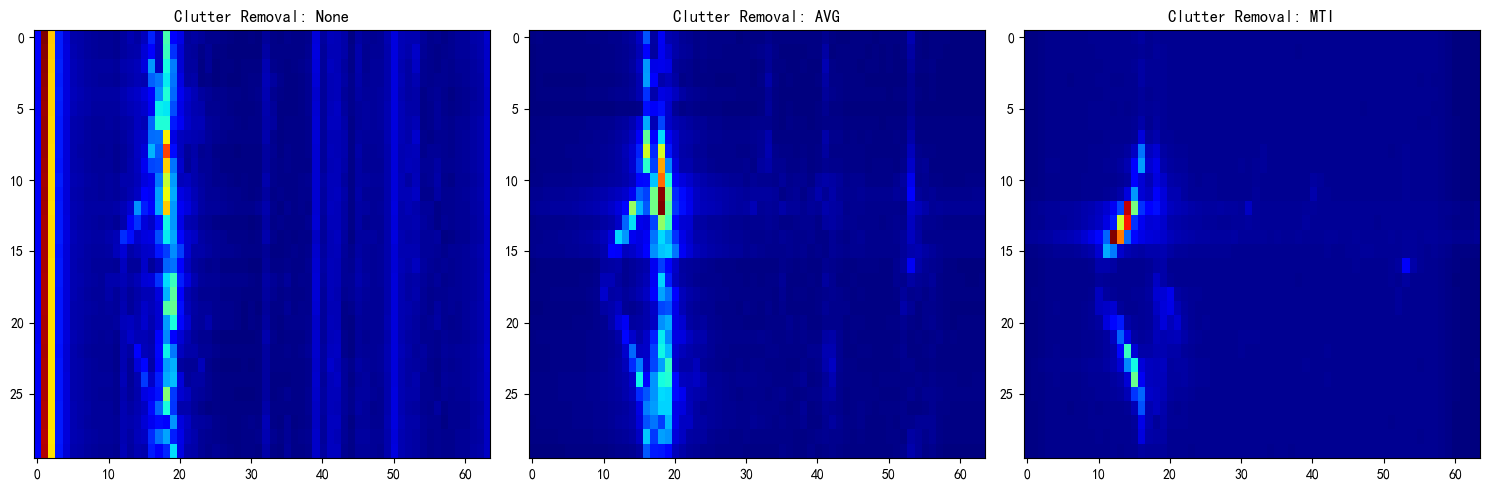

In [4]:
import matplotlib.pyplot as plt

# 处理第一个图像
range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar, clutter_removal=None, is_squeeze=True)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 创建1行3列的图像布局

axs[0].imshow(range_profile, aspect='auto', cmap='jet')
axs[0].set_title('Clutter Removal: None')

# 处理第二个图像
range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar, clutter_removal='avg', is_squeeze=True)

axs[1].imshow(range_profile, aspect='auto', cmap='jet')
axs[1].set_title('Clutter Removal: AVG')

# 处理第三个图像
range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar, clutter_removal='mti', is_squeeze=True)

axs[2].imshow(range_profile, aspect='auto', cmap='jet')
axs[2].set_title('Clutter Removal: MTI')

plt.tight_layout()  # 调整布局以防止重叠
plt.show()


(20, 64)


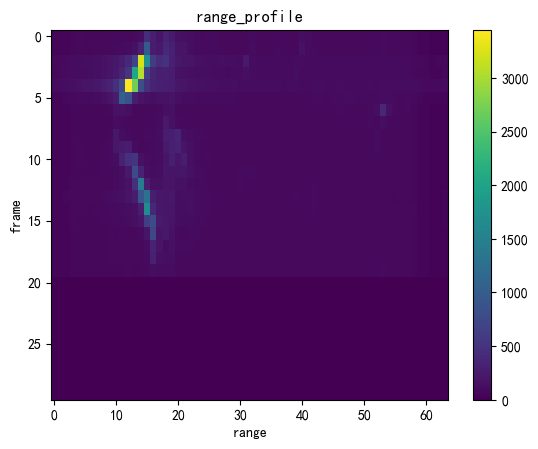

(30, 64)


In [5]:
# # 绘制range_profile
# plt.figure()
# plt.imshow(np.squeeze(range_profile), aspect='auto')
# plt.colorbar()
# plt.title('range_profile')
# plt.xlabel('range')
# plt.ylabel('frame')
# plt.show()
# 我想去掉前10帧的数据，然后补齐到30帧,丢进模型里面
c_range_profile = range_profile[10:,:]
print(c_range_profile.shape)

# 补齐到30帧
if c_range_profile.shape[0] < 30:
    c_range_profile = np.concatenate((c_range_profile, np.zeros((30-c_range_profile.shape[0],64))), axis=0)

plt.figure()
plt.imshow(np.squeeze(c_range_profile), aspect='auto')
plt.colorbar()
plt.title('range_profile')
plt.xlabel('range')
plt.ylabel('frame')
plt.show()

# 定义一个函数，用于处理数据(传入数据和需要去除的帧的列表),去除的帧直接置零
def process_data(data, remove_list):
    data[remove_list] = 0
    
    
    return data

# 去除前10帧
c_range_profile = process_data(range_profile, [0,1,2,3,4,5,6,7,8,9])
c_speed_profile = process_data(speed_profile, [0,1,2,3,4,5,6,7,8,9])
c_angle_profile = process_data(angle_profile, [0,1,2,3,4,5,6,7,8,9])

print(c_range_profile.shape)

# print(model(torch.tensor(np.expand_dims(range_profile, axis=0),dtype=torch.float32), torch.tensor(np.expand_dims(speed_profile, axis=0),dtype=torch.float32), torch.tensor(np.expand_dims(angle_profile, axis=0),dtype=torch.float32)))
# print(one_hot_to_label(model(torch.tensor(np.expand_dims(range_profile, axis=0),dtype=torch.float32), torch.tensor(np.expand_dims(speed_profile, axis=0),dtype=torch.float32), torch.tensor(np.expand_dims(angle_profile, axis=0),dtype=torch.float32))))

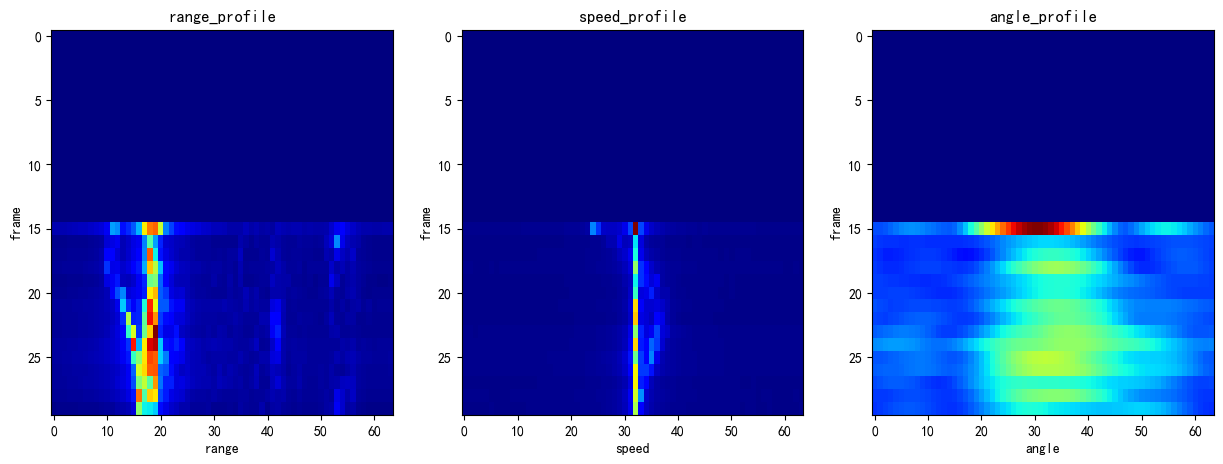

tensor([0])

In [15]:
# print(model(torch.tensor(np.expand_dims(range_profile, axis=0),dtype=torch.float32), torch.tensor(np.expand_dims(speed_profile, axis=0),dtype=torch.float32), torch.tensor(np.expand_dims(angle_profile, axis=0),dtype=torch.float32)))
# print(one_hot_to_label(model(torch.tensor(np.expand_dims(range_profile, axis=0),dtype=torch.float32), torch.tensor(np.expand_dims(speed_profile, axis=0),dtype=torch.float32), torch.tensor(np.expand_dims(angle_profile, axis=0),dtype=torch.float32))))

def load_data(file_path):
    with open(file_path, 'rb') as file:
        adcData = np.fromfile(file, dtype=np.int16)
    adcData = adcData.reshape(numLanes*2, -1,order='F')
    adcData = adcData[[0,1,2,3],:] + 1j*adcData[[4,5,6,7],:]
    data_radar = np.reshape(adcData, (n_RX, n_samples, n_chirps, n_frames), order='F')
    return data_radar

# 定义画图函数,用于绘制range_profile, speed_profile, angle_profile
def plot_profile(range_profile, speed_profile, angle_profile):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(range_profile, aspect='auto', cmap='jet')
    ax[0].set_title('range_profile')
    ax[0].set_xlabel('range')
    ax[0].set_ylabel('frame')
    ax[1].imshow(speed_profile, aspect='auto', cmap='jet')
    ax[1].set_title('speed_profile')
    ax[1].set_xlabel('speed')
    ax[1].set_ylabel('frame')
    ax[2].imshow(angle_profile, aspect='auto', cmap='jet')
    ax[2].set_title('angle_profile')
    ax[2].set_xlabel('angle')
    ax[2].set_ylabel('frame')
    plt.show()

# 将特征的前n帧数据置零,作为数据增强的方式
def process_data(range_profile, speed_profile, angle_profile, n):
    range_profile[:n] = 0
    speed_profile[:n] = 0
    angle_profile[:n] = 0
    
    
    return range_profile, speed_profile, angle_profile

def process_data(filename = None, clutter_removal = None,  n = 15):
    data_radar = load_data(filename)
    range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar, clutter_removal=clutter_removal, is_squeeze=True)
    range_profile[:n] = 0
    speed_profile[:n] = 0
    angle_profile[:n] = 0
    return range_profile, speed_profile, angle_profile

# 模型预测
def predict(range_profile, speed_profile, angle_profile):
    range_profile = torch.tensor(np.expand_dims(range_profile, axis=0),dtype=torch.float32)
    speed_profile = torch.tensor(np.expand_dims(speed_profile, axis=0),dtype=torch.float32)
    angle_profile = torch.tensor(np.expand_dims(angle_profile, axis=0),dtype=torch.float32)
    return one_hot_to_label(model(range_profile, speed_profile, angle_profile))

filename = 'K:/dataset/AA/1/2.bin'
range_profile, speed_profile, angle_profile = process_data(filename, clutter_removal='avg', n=15)
plot_profile(range_profile, speed_profile, angle_profile)
predict(range_profile, speed_profile, angle_profile)




In [87]:
def load_data(file_dir):
    data = sio.loadmat(file_dir)
    range_profile = data['range_profile']
    speed_profile = data['speed_profile']
    angle_profile = data['angle_profile']
    # print(range_profile.shape)  # (1000, 30, 64)
    return range_profile, speed_profile, angle_profile

# 定义画图函数,用于绘制range_profile, speed_profile, angle_profile
def plot_profile(range_profile, speed_profile, angle_profile):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(range_profile, aspect='auto', cmap='jet')
    ax[0].set_title('range_profile')
    ax[0].set_xlabel('range')
    ax[0].set_ylabel('frame')
    ax[1].imshow(speed_profile, aspect='auto', cmap='jet')
    ax[1].set_title('speed_profile')
    ax[1].set_xlabel('speed')
    ax[1].set_ylabel('frame')
    ax[2].imshow(angle_profile, aspect='auto', cmap='jet')
    ax[2].set_title('angle_profile')
    ax[2].set_xlabel('angle')
    ax[2].set_ylabel('frame')
    plt.show()

# 将特征的n帧的列表置零,作为数据增强的方式
def process_data(range_profile, speed_profile, angle_profile, n):
    range_profile[:,n,:] = 0
    speed_profile[:,n,:] = 0
    angle_profile[:,n,:] = 0
    
    return range_profile, speed_profile, angle_profile

def load_model(model_path):
    model = RadarGestureNet(gesture_class=10)
    model.load_state_dict(torch.load(model_path))
    return model

# 模型预测
def predict(range_profile, speed_profile, angle_profile, model):
    range_profile = torch.tensor(range_profile,dtype=torch.float32)
    speed_profile = torch.tensor(speed_profile,dtype=torch.float32)
    angle_profile = torch.tensor(angle_profile,dtype=torch.float32)
    return one_hot_to_label(model(range_profile, speed_profile, angle_profile))



# model = load_model('mti_model.pth')
# range_profile, speed_profile, angle_profile = load_data('K:/aio_radar/out/1000/mti/3.mat')
# plot_profile(np.abs(np.squeeze(range_profile[0])), np.abs(np.squeeze(speed_profile[0])), np.abs(np.squeeze(angle_profile[0])))
# # 前15
# range_profile, speed_profile, angle_profile = load_data('K:/aio_radar/out/1000/mti/3.mat')
# process_data(range_profile, speed_profile, angle_profile, list(range(15)))
# plot_profile(np.abs(np.squeeze(range_profile[0])), np.abs(np.squeeze(speed_profile[0])), np.abs(np.squeeze(angle_profile[0])))
# range_profile, speed_profile, angle_profile = load_data('K:/aio_radar/out/1000/mti/3.mat')
# # 后15
# process_data(range_profile, speed_profile, angle_profile, list(range(15,30)))
# plot_profile(np.abs(np.squeeze(range_profile[0])), np.abs(np.squeeze(speed_profile[0])), np.abs(np.squeeze(angle_profile[0])))

# 开始数据增强
# clutter_removal_list = ['avg', 'mti', 'None']
# class_list = [1,2,3,4]
clutter_removal_list = ['avg']
class_list = [1,2,3,4]

file_dir = 'K:/aio_radar/out/1000/'
for clutter_removal in clutter_removal_list:
    for class_name in class_list:
        range_profile, speed_profile, angle_profile = load_data(file_dir + clutter_removal + '/' + str(class_name) + '.mat')
        # 前15
        process_data(range_profile, speed_profile, angle_profile, list(range(15)))
        
        output_dir = file_dir + f'/{clutter_removal}/remove_0_15_{class_name}.mat'
        if not os.path.exists(os.path.dirname(output_dir)):
            os.makedirs(os.path.dirname(output_dir))
        
        
        sio.savemat(output_dir, {'range_profile':range_profile, 'speed_profile':speed_profile, 'angle_profile':angle_profile})
        
        # 后15
        range_profile, speed_profile, angle_profile = load_data(file_dir + clutter_removal + '/' + str(class_name) + '.mat')
        process_data(range_profile, speed_profile, angle_profile, list(range(15,30)))
        
        output_dir = file_dir + f'/{clutter_removal}/remove_15_30_{class_name}.mat'
        if not os.path.exists(os.path.dirname(output_dir)):
            os.makedirs(os.path.dirname(output_dir))
        
        sio.savemat(output_dir, {'range_profile':range_profile, 'speed_profile':speed_profile, 'angle_profile':angle_profile})



In [88]:
# 用于合并特征
import os
import scipy.io as sio
import numpy as np


# 原特征路径1
feature_path1 = 'out/1000/avg_remove'
feature_path2 = 'out/1000/avg_remove'

out_path = 'out/1000/avg_remove'

for i in range(1, 5):
    data1 = sio.loadmat(os.path.join(feature_path1, f'remove_0_15_{i}.mat'))
    range_profile1 = data1['range_profile']
    speed_profile1 = data1['speed_profile']
    angle_profile1 = data1['angle_profile']
    feature2 = sio.loadmat(os.path.join(feature_path2, f'remove_15_30_{i}.mat'))
    range_profile2 = feature2['range_profile']
    speed_profile2 = feature2['speed_profile']
    angle_profile2 = feature2['angle_profile']
    print(range_profile1.shape)
    print(range_profile2.shape)
    
    range_profile = np.concatenate((range_profile1, range_profile2), axis=0)
    speed_profile = np.concatenate((speed_profile1, speed_profile2), axis=0)
    angle_profile = np.concatenate((angle_profile1, angle_profile2), axis=0)
    print(range_profile.shape)
    sio.savemat(os.path.join(out_path, f'{i}.mat'), {'range_profile': range_profile, 'speed_profile': speed_profile, 'angle_profile': angle_profile})

(1000, 30, 64)
(1000, 30, 64)
(2000, 30, 64)
(1000, 30, 64)
(1000, 30, 64)
(2000, 30, 64)
(1000, 30, 64)
(1000, 30, 64)
(2000, 30, 64)
(1000, 30, 64)
(1000, 30, 64)
(2000, 30, 64)


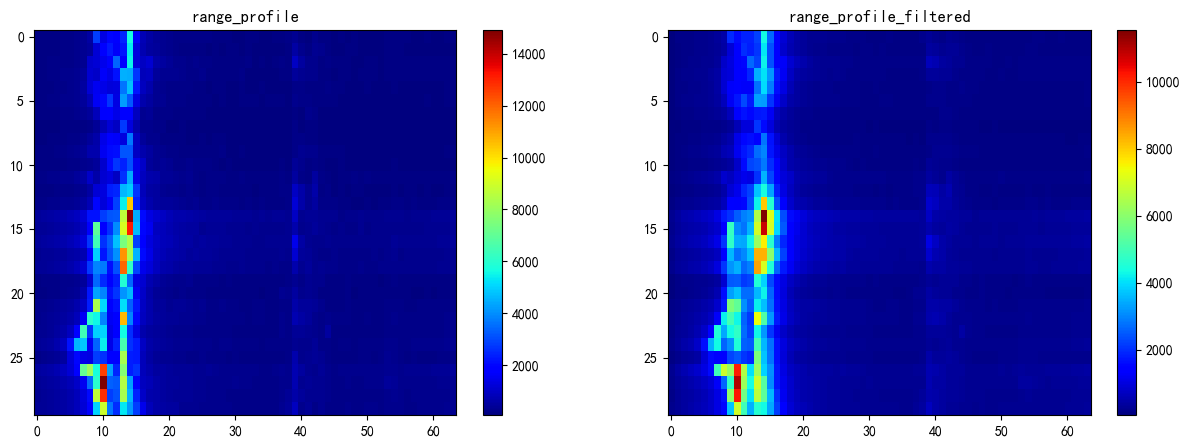

In [ ]:
# 卡尔曼滤波
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# 创建一个卡尔曼滤波器(initial_state_mean: 初始状态均值, n_dim_obs: 观测值维度)
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# 初始化一个空的数组来存储滤波后的数据
range_profile_filtered = np.zeros_like(range_profile)

# 对每一帧的数据应用卡尔曼滤波
for i in range(range_profile.shape[0]):
    range_profile_filtered[i, :] = np.squeeze(kf.filter(range_profile[i, :])[0])

# 创建一个新的图像窗口
plt.figure(figsize=(15, 5))

# 创建第一个子图，显示原始数据
plt.subplot(1, 2, 1)
plt.imshow(range_profile, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('range_profile')

# 创建第二个子图，显示滤波后的数据
plt.subplot(1, 2, 2)
plt.imshow(range_profile_filtered, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('range_profile_filtered')

# 显示图像
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


# 单个文件特征提取
def feature_extraction_single(filename, clutter_removal=None,N=64,M=64,Q=64,numLanes=4,n_RX=4,n_samples=64,n_chirps=255,n_frames=30):
    # 读取文件
    with open(filename, 'rb') as file:
        adcData = np.fromfile(file, dtype=np.int16)

    # 实部虚部结合
    adcData = adcData.reshape(numLanes*2, -1, order='F')
    
    # reshaped_data = np.zeros((numLanes*2, adcData.size//(numLanes*2)), dtype=np.int16)
    # 自己写上面注释掉的代码(一个一个赋值到data)
    # for i in range(adcData.size):
    #     row = i % (numLanes*2)  # 行号
    #     col = i // (numLanes*2)  # 列号
    #     reshaped_data[row, col] = adcData[i]
    # adcData = reshaped_data
    
    adcData = adcData[[0,1,2,3], :] + 1j*adcData[[4,5,6,7], :]
    # 自己写上面注释掉的代码(一个一个赋值到data)
    
    # temp = np.zeros((numLanes, adcData.shape[1]), dtype=np.complex128)
    
    # # 用多重循环赋值
    # for i in range(adcData.shape[1]):
    #     for j in range(numLanes):
    #         temp[j, i] = adcData[j, i] + 1j * adcData[j+4, i]    
    # adcData = temp
    
    
    
    data_radar = np.reshape(adcData, (n_RX, n_samples, n_chirps, n_frames), order='F')
    
    # 绘制data_radar[0,:,0,0]的图像
    plt.figure()
    plt.plot(np.abs(data_radar[0,:,0,0]))
    plt.show()
    
    print(data_radar[0,:,0,0])
    
    # data_radar = np.zeros((n_RX, n_samples, n_chirps, n_frames), dtype=np.complex128)
    
    # # 自己写上面注释掉的代码(一个一个赋值到data)
    # # 用多重循环赋值
    # for i in range(n_RX):
    #     for j in range(n_samples):
    #         for k in range(n_chirps):
    #             for l in range(n_frames):
    #                 data_radar[i, j, k, l] = adcData[i, j + k * n_samples + l * n_samples * n_chirps]
    
    if data_radar.ndim == 3:
        data_radar = data_radar[:, :, :, np.newaxis]

    range_profile = np.fft.fft(data_radar, N, axis=1)
    
    print(range_profile.shape)
    # # 自己写上面注释掉的代码(一个一个赋值到data)
    # range_profile = np.zeros((n_RX, N, n_chirps, n_frames), dtype=np.complex128)
    
    # # 用多重循环赋值
    # for i in range(n_RX):
    #     for j in range(n_chirps):
    #         for k in range(n_frames):
    #             range_profile[i, :, j, k] = np.fft.fft(data_radar[i, :, j, k], N)
                

    if clutter_removal == 'avg':
        range_profile = range_profile - np.mean(range_profile, axis=2)[:, :, np.newaxis, :]
        print(np.mean(range_profile, axis=2).shape)
        pass
    elif clutter_removal == 'mti':
        # [ ] 执行移动目标指示（MTI）滤波
        pass
    else:
        pass

    speed_profile= np.fft.fftshift(np.fft.fft(range_profile, M, axis=2), axes=2) 
    speed_profile = np.fft.fft(range_profile, M, axis=2)
    speed_profile = np.fft.fftshift(speed_profile, axes=2)
    
    

    angle_profile = np.fft.fftshift(np.fft.fft(speed_profile, Q, axis=0), axes=0)
    angle_profile = np.fft.fft(speed_profile, Q, axis=0)
    

    range_profile = np.squeeze(np.mean(np.abs(range_profile), axis=(0, 2))).T
    speed_profile = np.squeeze(np.mean(np.abs(speed_profile), axis=(0, 1))).T
    angle_profile = np.squeeze(np.mean(np.abs(angle_profile), axis=(1, 2))).T
    
    print(range_profile.shape)
    
    return range_profile, speed_profile, angle_profile

range_profile, speed_profile, angle_profile = feature_extraction_single('K:/dataset/2024_3_22/1/1.bin', clutter_removal='avg')

# import matplotlib.pyplot as plt
# plt.figure()
# plt.imshow(range_profile)
# plt.colorbar()
# plt.show()

# 查看range_profile的shape
print(range_profile.shape)

# 绘制range_profile的热图
plt.figure()
plt.imshow(range_profile)
plt.colorbar()
plt.show()

# 绘制speed_profile的热图
plt.figure()
plt.imshow(speed_profile)
plt.colorbar()
plt.show()

# 绘制angle_profile的热图
plt.figure()
plt.imshow(angle_profile)
plt.colorbar()
plt.show()

